# Day 4: ARIMA and Forecasting
## Week 3: Time Series Analysis for Finance

---

### 🎯 Learning Objectives
- Understand ARIMA(p,d,q) models
- Build forecasting pipelines
- Evaluate forecast accuracy
- Handle non-stationary data

---

### 📈 Why ARIMA Matters in Trading

**What is ARIMA?**

ARIMA = AutoRegressive Integrated Moving Average. The "I" (Integrated) adds **differencing** to make non-stationary data stationary. This allows us to model price data directly.

### Trading Applications

| Application | How ARIMA Helps |
|-------------|----------------|
| **Price Forecasting** | Predict next price (wide confidence intervals) |
| **Spread Forecasting** | When will pairs spread revert? |
| **Macro Forecasting** | GDP, inflation, interest rates |
| **Benchmark Model** | Compare ML models against ARIMA baseline |

### 🎯 When to Use ARIMA vs ARMA

| Data Type | Use | Why |
|-----------|-----|-----|
| **Prices** | ARIMA (d=1) | Prices are non-stationary |
| **Returns** | ARMA (d=0) | Returns are already stationary |
| **Log Prices** | ARIMA (d=1) | Still non-stationary |
| **Spreads** | Test first | May or may not need differencing |

### Reality Check for Traders

**What to expect from ARIMA forecasts:**
- Short-term: Reasonable point estimates
- Long-term: Converges to mean (flat line)
- Confidence intervals: Widen rapidly
- Directional accuracy: ~50-55% at best

**ARIMA is MORE useful for:**
- Mean-reverting spreads
- Interest rate forecasting
- As a benchmark to beat

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. ARIMA(p,d,q) Models

### What is ARIMA?
ARIMA = AutoRegressive Integrated Moving Average

### 🎯 Parameter Meanings for Trading

| Parameter | Name | Trading Interpretation |
|-----------|------|------------------------|
| **p** | AR order | How many past PRICES affect today |
| **d** | Differencing | 1 for prices, 0 for returns |
| **q** | MA order | How many past SHOCKS affect today |

4. **Or**: Use auto_arima() to search automatically

### When to Use Each 'd' Value3. **q**: Look at ACF of differenced series → significant lags = q

2. **p**: Look at PACF of differenced series → significant lags = p

| d Value | When to Use | Example |1. **d**: Use ADF test → if p > 0.05, need differencing

|---------|-------------|--------|

| **d=0** | Data is stationary | Returns, some spreads |### How to Choose p, d, q

| **d=1** | Data has unit root | Prices, most financial series |

| **d=2** | After d=1 still non-stationary | Rarely needed || ARIMA(1,1,0) | AR model on prices |

| ARIMA(0,1,0) | Random walk (naive forecast) |

### Common ARIMA Models in Finance| ARIMA(1,0,1) | Returns data (same as ARMA) |

| ARIMA(1,1,1) | Price data baseline |

| Model | Use Case ||-------|----------|

ARIMA: DIFFERENCING PARAMETER (d)

ADF Test Results at Different Differencing Levels:
--------------------------------------------------
d=0 (Original)           : ADF stat = -1.1174, p = 0.7081 ✗
d=1 (First Diff)         : ADF stat = -33.7041, p = 0.0000 ✓
d=2 (Second Diff)        : ADF stat = -13.6904, p = 0.0000 ✓

→ d=1 is sufficient for price data


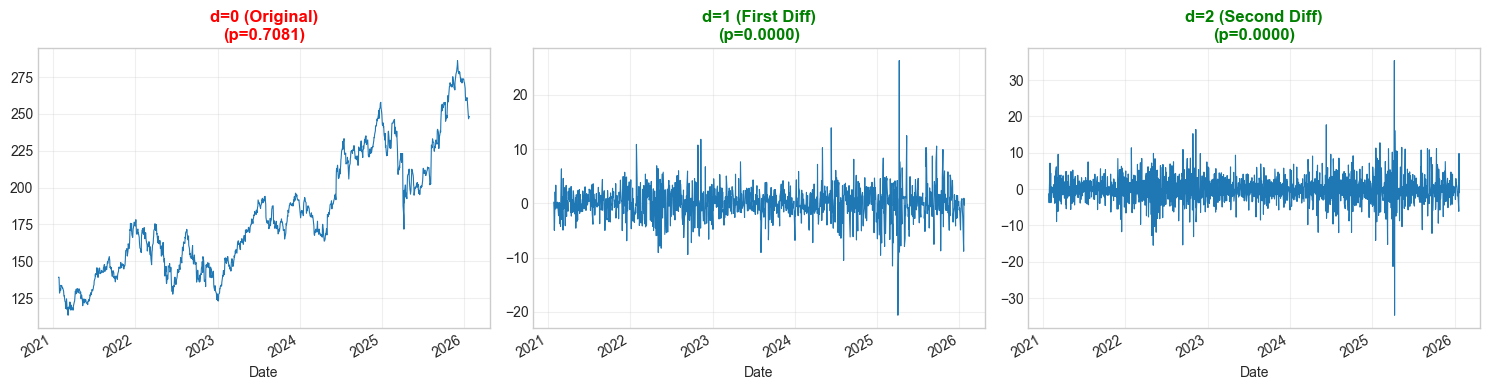

In [2]:
# Understanding the 'd' parameter
print("=" * 60)
print("ARIMA: DIFFERENCING PARAMETER (d)")
print("=" * 60)

aapl_price = prices['AAPL']

# Test stationarity at different differencing levels
print("\nADF Test Results at Different Differencing Levels:")
print("-" * 50)

series_dict = {
    'd=0 (Original)': aapl_price,
    'd=1 (First Diff)': aapl_price.diff().dropna(),
    'd=2 (Second Diff)': aapl_price.diff().diff().dropna()
}

for name, series in series_dict.items():
    adf_stat, adf_p = adfuller(series.dropna())[:2]
    stationary = '✓' if adf_p < 0.05 else '✗'
    print(f"{name:<25}: ADF stat = {adf_stat:.4f}, p = {adf_p:.4f} {stationary}")

print("\n→ d=1 is sufficient for price data")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, series) in zip(axes, series_dict.items()):
    series.plot(ax=ax, lw=0.8)
    adf_p = adfuller(series.dropna())[1]
    color = 'green' if adf_p < 0.05 else 'red'
    ax.set_title(f'{name}\n(p={adf_p:.4f})', fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
# Fit ARIMA on price data
print("=" * 60)
print("ARIMA MODEL ON PRICE DATA")
print("=" * 60)

# ARIMA(1,1,1) on prices
model = ARIMA(aapl_price, order=(1, 1, 1))
fit = model.fit()

print(fit.summary())

ARIMA MODEL ON PRICE DATA
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1256
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3190.889
Date:                Sat, 24 Jan 2026   AIC                           6387.778
Time:                        10:15:25   BIC                           6403.183
Sample:                             0   HQIC                          6393.568
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1474      0.399      0.370      0.712      -0.634       0.929
ma.L1         -0.0978      0.401     -0.244      0.807      -0.884       0.688
sigma2         9.4613     

## 2. Train-Test Split for Time Series

- This is called "look-ahead bias" - career-ending mistake!

### 🎯 Why Time Series Splits are Different- Strategy will fail in live trading

- Backtest will show unrealistic profits

**CRITICAL: Never shuffle time series data!**If you accidentally include future data in training:

In finance, we MUST respect time order to avoid look-ahead bias.

### Why This Matters in Trading

| Split Method | Regular ML | Time Series |

|--------------|-----------|-------------|| **Expanding** | All prior data | Each next day | Growing history |

| **Shuffling** | ✅ OK | ❌ NEVER || **Walk-Forward** | Rolling window | Each next day | Production systems |

| **Order** | Random | Chronological || **Simple** | First 80% | Last 20% | Quick backtesting |

| **Future data** | Can appear in train | Must be in test only ||----------|----------|---------|----------|

| Strategy | Training | Testing | Use Case |

### Typical Splits for Trading

TIME SERIES TRAIN-TEST SPLIT
Training period: 2021-01-25 to 2025-01-22
Testing period:  2025-01-23 to 2026-01-23
Training samples: 1004
Testing samples:  252


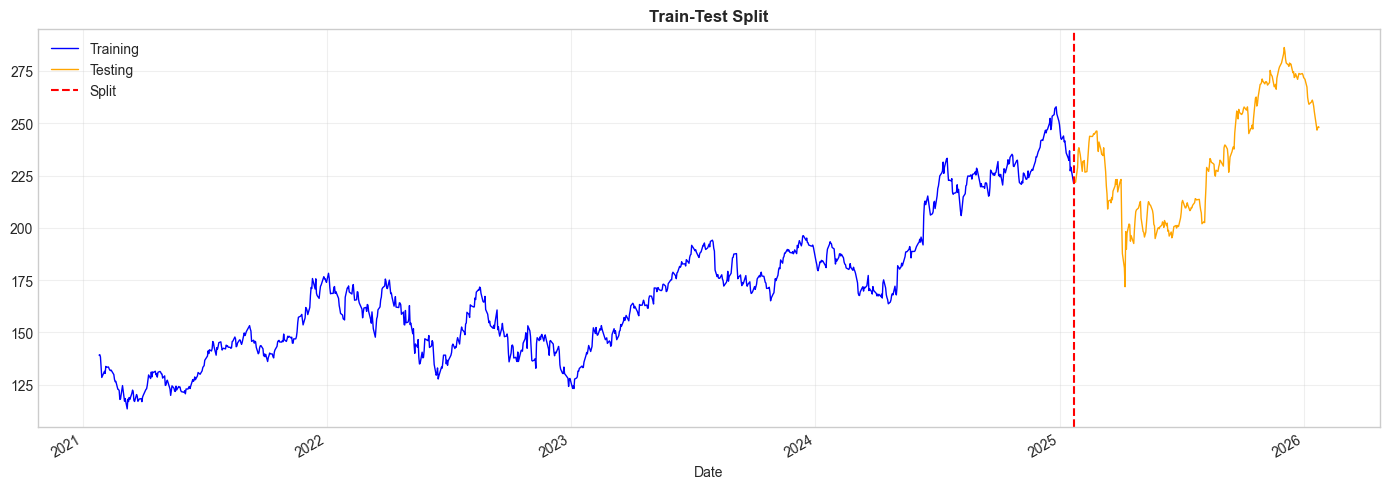

In [4]:
# Time series train-test split
print("=" * 60)
print("TIME SERIES TRAIN-TEST SPLIT")
print("=" * 60)

# Use last 20% for testing
split_idx = int(len(aapl_price) * 0.8)
train = aapl_price[:split_idx]
test = aapl_price[split_idx:]

print(f"Training period: {train.index[0].date()} to {train.index[-1].date()}")
print(f"Testing period:  {test.index[0].date()} to {test.index[-1].date()}")
print(f"Training samples: {len(train)}")
print(f"Testing samples:  {len(test)}")

# Visualize split
fig, ax = plt.subplots(figsize=(14, 5))

train.plot(ax=ax, label='Training', color='blue', lw=1)
test.plot(ax=ax, label='Testing', color='orange', lw=1)
ax.axvline(train.index[-1], color='red', linestyle='--', label='Split')
ax.set_title('Train-Test Split', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Forecasting with ARIMA

| Narrow CI | High confidence, normal position |

### 🎯 Types of Forecasts| Wide CI | Low confidence, reduce position |

| Forecast < Current | Bearish (sell signal) |

| Forecast Type | Description | Trading Use || Forecast > Current | Bullish (buy signal) |

|---------------|-------------|-------------||--------|---------------|

| **Multi-step** | Predict many days ahead at once | Macro forecasting || Signal | Interpretation |

| **Rolling** | Predict 1 day, update, repeat | Realistic backtesting |

| **Recursive** | Use predictions to make predictions | Long-term scenarios |### Trading Signal Generation



### What You'll See in Trading Reality- More honest performance metrics

- Mimics real trading conditions

**Multi-step forecast problems:**- Uses actual data as it arrives

- Converges to mean quickly (flat line)**Why rolling forecasts are better:**

- Confidence intervals explode
- Almost useless after few days

ARIMA FORECASTING


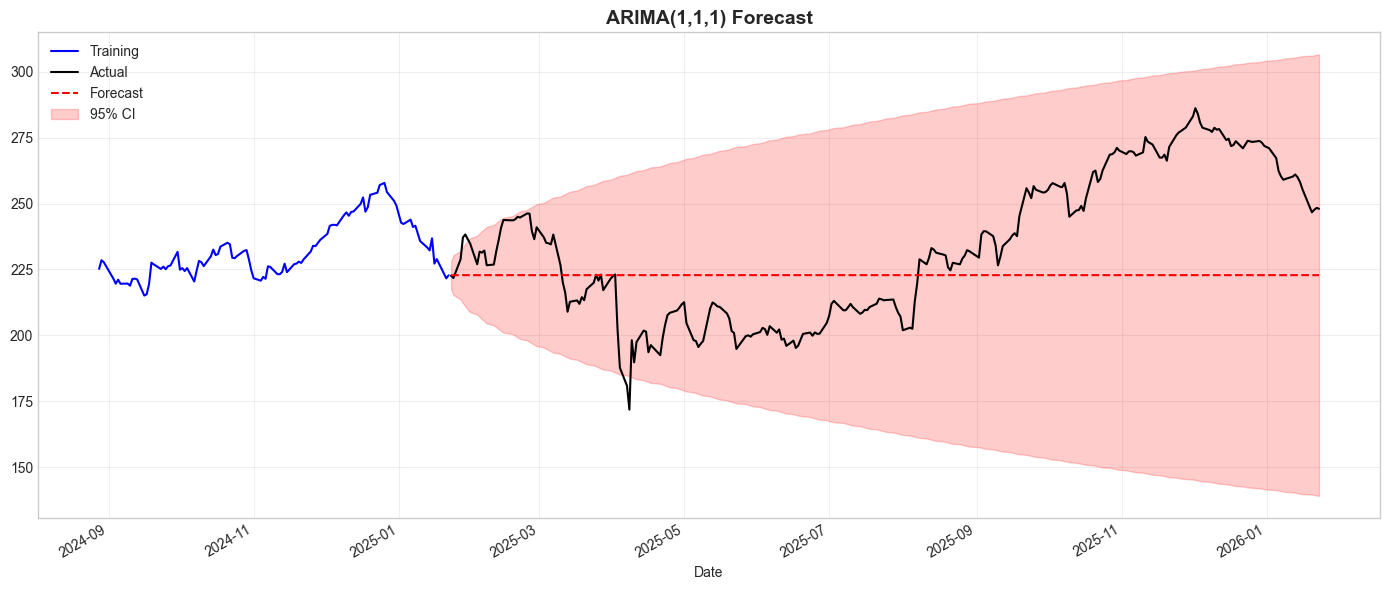


⚠️ Notice how forecast quickly converges to a straight line!
   This is typical for ARIMA on financial data.


In [5]:
# ARIMA Forecasting
print("=" * 60)
print("ARIMA FORECASTING")
print("=" * 60)

# Fit on training data
model = ARIMA(train, order=(1, 1, 1))
fit = model.fit()

# Forecast
forecast_steps = len(test)
forecast = fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int(alpha=0.05)

# Set index to match test
forecast_mean.index = test.index
forecast_ci.index = test.index

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

# Plot last portion of training
train[-100:].plot(ax=ax, label='Training', color='blue', lw=1.5)
test.plot(ax=ax, label='Actual', color='black', lw=1.5)
forecast_mean.plot(ax=ax, label='Forecast', color='red', linestyle='--', lw=1.5)

ax.fill_between(forecast_ci.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1],
                alpha=0.2, color='red', label='95% CI')

ax.set_title('ARIMA(1,1,1) Forecast', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ Notice how forecast quickly converges to a straight line!")
print("   This is typical for ARIMA on financial data.")

## 4. Forecast Evaluation Metrics

| >60% | Suspicious (check for bugs/leakage) |

### 🎯 Which Metric Matters for Trading?| 55-60% | Strong edge (rare, validate carefully) |

| 52-55% | Slight edge (tradeable with good risk management) |

| Metric | What it Measures | Trading Relevance || 50% | Random guessing |

|--------|------------------|-------------------||---------------------|--------|

| **MAE** | Average error | Good for P&L estimation || Directional Accuracy | Meaning |

| **RMSE** | Penalizes big errors | Risk management |

| **MAPE** | Percentage error | Cross-asset comparison |### Realistic Expectations

| **Direction** | Up/Down accuracy | **MOST IMPORTANT for trading** |

| Worse both | Useless | Don't trade with it |

### Why Directional Accuracy Matters Most| Better Direction | Tradeable? | Still need risk checks |

| Better RMSE | Promising | But check direction |

In trading, being right about DIRECTION matters more than exact price:|------------|----------------|----------------|

- If you predict "up" and it goes up → profit (regardless of magnitude)| Your Model | vs Random Walk | Interpretation |

- If you predict exact price but wrong direction → loss

**Random Walk = Naive forecast (last price repeated)**

### Benchmark: Beat the Random Walk

In [6]:
# Forecast evaluation metrics
print("=" * 60)
print("FORECAST EVALUATION METRICS")
print("=" * 60)

def evaluate_forecast(actual, predicted, name='Model'):
    """Calculate forecast evaluation metrics."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Directional accuracy (for returns)
    actual_dir = np.sign(actual.diff().dropna())
    pred_dir = np.sign(predicted.diff().dropna())
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    print(f"\n{name}:")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Directional Accuracy: {dir_acc:.1f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'Dir_Acc': dir_acc}

# Evaluate ARIMA forecast
arima_metrics = evaluate_forecast(test, forecast_mean, 'ARIMA(1,1,1)')

# Compare with naive forecast (random walk)
naive_forecast = train.iloc[-1]  # Last value repeated
naive_series = pd.Series([naive_forecast] * len(test), index=test.index)

naive_metrics = evaluate_forecast(test, naive_series, 'Naive (Random Walk)')

FORECAST EVALUATION METRICS

ARIMA(1,1,1):
  MAE:  $24.28
  RMSE: $29.06
  MAPE: 10.08%
  Directional Accuracy: 10.0%

Naive (Random Walk):
  MAE:  $24.29
  RMSE: $29.07
  MAPE: 10.08%
  Directional Accuracy: 0.0%


ROLLING ONE-STEP-AHEAD FORECAST
Performing rolling forecast (this may take a moment)...
  Completed 50/252 forecasts
  Completed 100/252 forecasts
  Completed 150/252 forecasts
  Completed 200/252 forecasts
  Completed 250/252 forecasts

Rolling ARIMA(1,1,1):
  MAE:  $2.77
  RMSE: $4.24
  MAPE: 1.24%
  Directional Accuracy: 54.2%


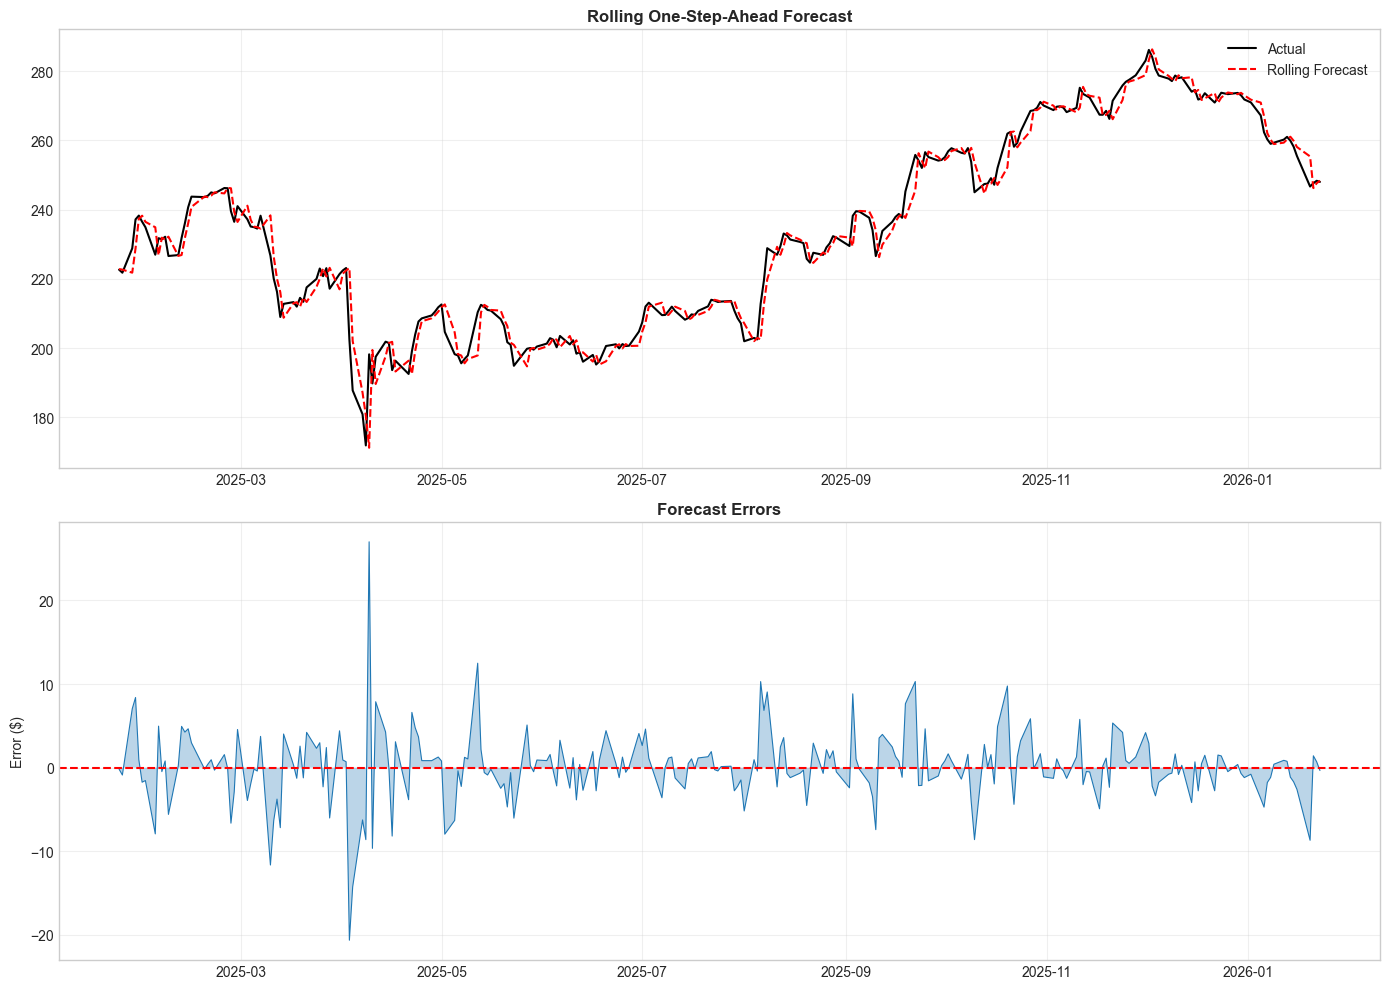

In [7]:
# Rolling forecast (one-step-ahead)
print("=" * 60)
print("ROLLING ONE-STEP-AHEAD FORECAST")
print("=" * 60)

# More realistic: one-step-ahead forecasts
rolling_forecasts = []
history = list(train)

print("Performing rolling forecast (this may take a moment)...")

for i, actual in enumerate(test):
    # Fit model on history
    model = ARIMA(history, order=(1, 1, 1))
    fit = model.fit()
    
    # One-step forecast
    fc = fit.forecast(steps=1)[0]
    rolling_forecasts.append(fc)
    
    # Add actual to history
    history.append(actual)
    
    if (i + 1) % 50 == 0:
        print(f"  Completed {i+1}/{len(test)} forecasts")

rolling_forecasts = pd.Series(rolling_forecasts, index=test.index)

# Evaluate rolling forecast
rolling_metrics = evaluate_forecast(test, rolling_forecasts, 'Rolling ARIMA(1,1,1)')

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full forecast
axes[0].plot(test.index, test.values, label='Actual', color='black', lw=1.5)
axes[0].plot(test.index, rolling_forecasts.values, label='Rolling Forecast', 
             color='red', linestyle='--', lw=1.5)
axes[0].set_title('Rolling One-Step-Ahead Forecast', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = test - rolling_forecasts
axes[1].plot(errors, lw=0.8)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].fill_between(errors.index, errors, 0, alpha=0.3)
axes[1].set_title('Forecast Errors', fontweight='bold')
axes[1].set_ylabel('Error ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FORECASTING RETURNS vs PRICES

Return Forecast Results:
  Directional Accuracy: 51.8%
  (Random would give ~50%)


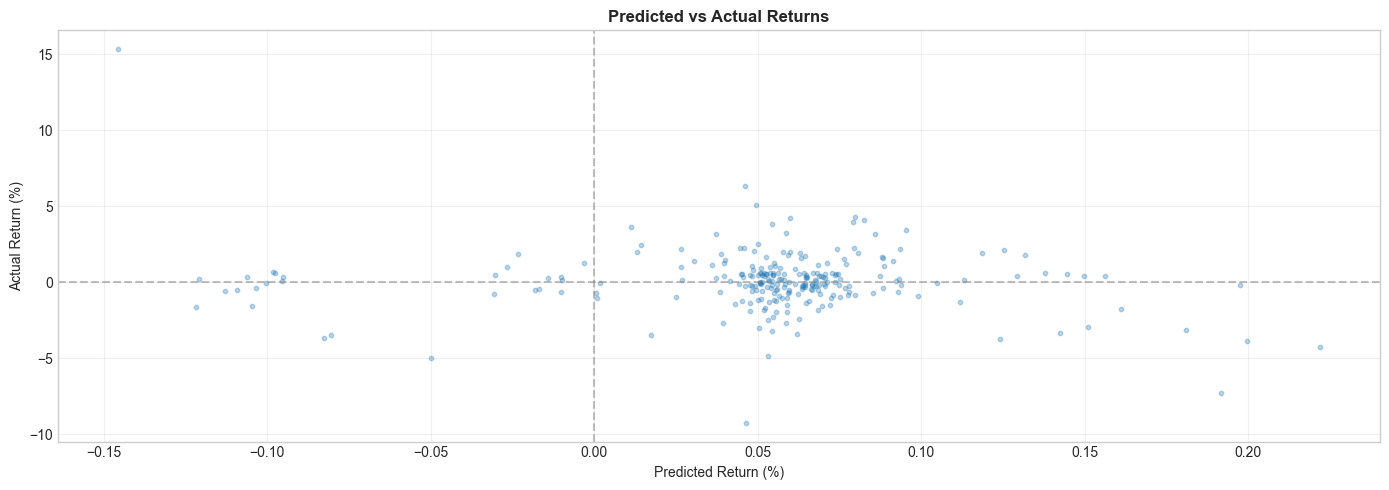

In [8]:
# Compare forecasting on returns vs prices
print("=" * 60)
print("FORECASTING RETURNS vs PRICES")
print("=" * 60)

aapl_returns = returns['AAPL'] * 100
split_idx = int(len(aapl_returns) * 0.8)
train_ret = aapl_returns[:split_idx]
test_ret = aapl_returns[split_idx:]

# Fit ARMA on returns (d=0 since returns are stationary)
model_ret = ARIMA(train_ret, order=(1, 0, 1))
fit_ret = model_ret.fit()

# Rolling forecast on returns
ret_forecasts = []
history_ret = list(train_ret)

for i, actual in enumerate(test_ret):
    model = ARIMA(history_ret, order=(1, 0, 1))
    fit = model.fit()
    fc = fit.forecast(steps=1)[0]
    ret_forecasts.append(fc)
    history_ret.append(actual)

ret_forecasts = pd.Series(ret_forecasts, index=test_ret.index)

# Directional accuracy
actual_dir = np.sign(test_ret)
pred_dir = np.sign(ret_forecasts)
dir_acc = (actual_dir == pred_dir).mean() * 100

print(f"\nReturn Forecast Results:")
print(f"  Directional Accuracy: {dir_acc:.1f}%")
print(f"  (Random would give ~50%)")

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))

ax.scatter(ret_forecasts, test_ret, alpha=0.3, s=10)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Predicted Return (%)')
ax.set_ylabel('Actual Return (%)')
ax.set_title('Predicted vs Actual Returns', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 4

### ARIMA Components:
- **p**: AR order (lags of the series)
- **d**: Differencing (1 for prices, 0 for returns)
- **q**: MA order (lags of errors)

### Forecasting Best Practices:
1. Use train-test split (time-based, no shuffle!)
2. Rolling forecasts more realistic than multi-step
3. Compare against naive benchmark
4. Focus on directional accuracy for trading

### Key Metrics:
| Metric | Use Case |
|--------|----------|
| MAE | Average error magnitude |
| RMSE | Penalizes large errors |
| MAPE | Percentage error |
| Directional Accuracy | Trading signals |

### Reality Check:
- ARIMA forecasts quickly revert to mean
- Financial returns are nearly unpredictable
- Don't expect >55% directional accuracy!

### Interview Questions:
- "What does the 'd' in ARIMA stand for?"
- "How do you evaluate forecast accuracy?"
- "Why use rolling forecasts instead of multi-step?"

## 🔴 PROS & CONS: ARIMA Forecasting

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [9]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - ARIMA Forecasting Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 10:15

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72
   MSFT: $465.95

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
